# Embeddings

Watch this video to get the understanding of what word embeddings are - https://www.youtube.com/watch?v=5PL0TmQhItY

Word embeddings are dense vector representations of words. The main advantage of word embeddings compared to one-hot representations is that similar words have similar embeddings (one hot vectors are orthogonal and you can't compute similarity between them).

Until about 2013 were usually computed using different matrix factorization algorithms. In 2013 Mikolov et. al proposed a much more efficient approach (Word2vec). Word2vec can be trained on much larger datasets which positivly affects the quality of the embeddings. 

Today Word2Vec and its later introduced improvement Fastext are not state-of-the-art aproaches. Contextual embeddings from ELMO and BERT are better. However, Word2Vec\Fastext are still widely used because they are much faster and easier to train than the contextual embeddings.

In this notebook you will learn how to compute embeddings usig matrix factorizations and Wor2Vec\FastText. 

In [1]:
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
%matplotlib inline

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Word embeddings are trained using unlabeled textual data. We'll use news texts from Reuters corpus to train our models.

In [81]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/mnefedov/nltk_data...


True

In [82]:
from nltk.corpus import reuters

In [172]:
docs = list(reuters.paras())

news = []

for doc in docs:
    text = ' '.join([' '.join(paragraph) for paragraph in doc])
    news.append(text)

In [176]:
news[:1]

['ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia \' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long - run , in the short - term Tokyo \' s loss might be their gain . The U . S . Has said it will impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan \' s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at 10 billion dlrs and spokesmen for major electronics firms said they would virtually halt exports of produc

In [177]:
len(news)

11887

In [30]:
train_ = pd.read_csv('msr_paraphrase_train.txt', sep='\t', engine='python', quoting=3)

## Matrix factorizations

In SVD and in NMF one of the resulting matrices has a shape of (number of words, number of components) so we can interpret each row in it as a word embedding.

We will factorize a documents-words matrix returned by CountVectorizer from sklearn.

In [178]:
cv = CountVectorizer(min_df=10, max_features=5000)
X = cv.fit_transform(news)

In [179]:
X.shape

(11887, 5000)

Let's try 2 components to be able to visualize our vectors.

In [180]:
svd = NMF(2)
svd.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=2, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [181]:
# embedding matrix
svd.components_.T.shape

(5000, 2)

In [182]:
# or we can use a larger number of components
# but pass the resulting matrix through TSNE (another factorization algo that is good for visualization)
# svd = TruncatedSVD(200)
# svd.fit(X)
# tsne = TSNE(2).fit_transform(svd.components_.T)

In [183]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

We can't plot all the words, so we'll take a small subset. 

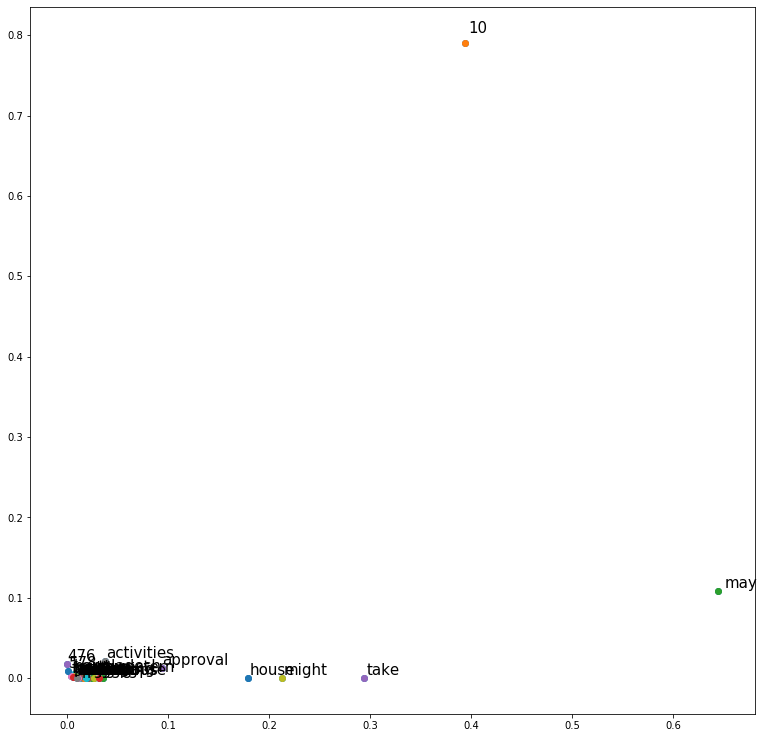

In [184]:
random_inds = np.random.choice(range(len(id2word)), 30, replace=False) 
res = svd.components_.T[random_inds] # comment this line for TSNE
# res = tsne[random_inds] # uncomment this line for TSNE

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

We should see similar words close to each other. But unfortunately we don't.

Visualization is usually a bad choice for interpreting or evaluation embeddings.

Let's try increasing the number of components (=dimension of our embeddings) and try to find similar words using cosine distance.

In [185]:
nmf = NMF(100)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=100, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [186]:
svd = TruncatedSVD(100)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

In [187]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [188]:
id2vec_svd = nmf.components_.T

In [189]:
id2vec_nmf = svd.components_.T

In [190]:
# a fuction to find a top 10 similar words in the embeding space
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [191]:
most_similar('bank', id2vec_svd)
# try other words

['bank',
 'cds',
 'colonial',
 'irving',
 'banco',
 'liberty',
 'branch',
 'citizens',
 'governor',
 'central']

In [192]:
most_similar("policy", id2vec_nmf)

['policy',
 'aggregates',
 'monetary',
 'reserve',
 'suggest',
 'economists',
 'pressures',
 'fed',
 'ease',
 'window']

We get some actually similar words, but results are still not ideal. Inspecting our model word by word is hard, so we can try to cluster all the words in our dictionary and inspect the cluster instead.

We'll use MiniBatchKmeans.

In [198]:
cluster = MiniBatchKMeans(500, n_init=2, verbose=0, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(nmf.components_.T)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=100,
        n_clusters=500, n_init=2, random_state=None,
        reassignment_ratio=0.4, tol=0.0, verbose=0)

We can save all clusters to a textfile

In [199]:

cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(id2word[i])
# open the file in any text editor
f = open('cluster_nmf.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

Or print clusters separately

In [209]:
cls[2]

['adoption',
 'importer',
 'intervenes',
 'juice',
 'necessarily',
 'prepare',
 'promotion',
 'removal',
 'self',
 'strict']

In [210]:
cls[3]

['associate',
 'former',
 'intention',
 'listed',
 'manila',
 'newspaper',
 'planters']

## Word2Vec and Fasttext

Let's do the same thing for Word2Vec and Fastext. 

There's implementations of both Word2vec and Fastext in gensim. The interface is similar to LDA except you don't need to build a dictionary.

In [211]:
fast_text = gensim.models.FastText([text.split() for text in news], size=50, 
                                   min_n=4, max_n=8) 
w2v = gensim.models.Word2Vec([text.split() for text in news], size=50, sg=1)


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


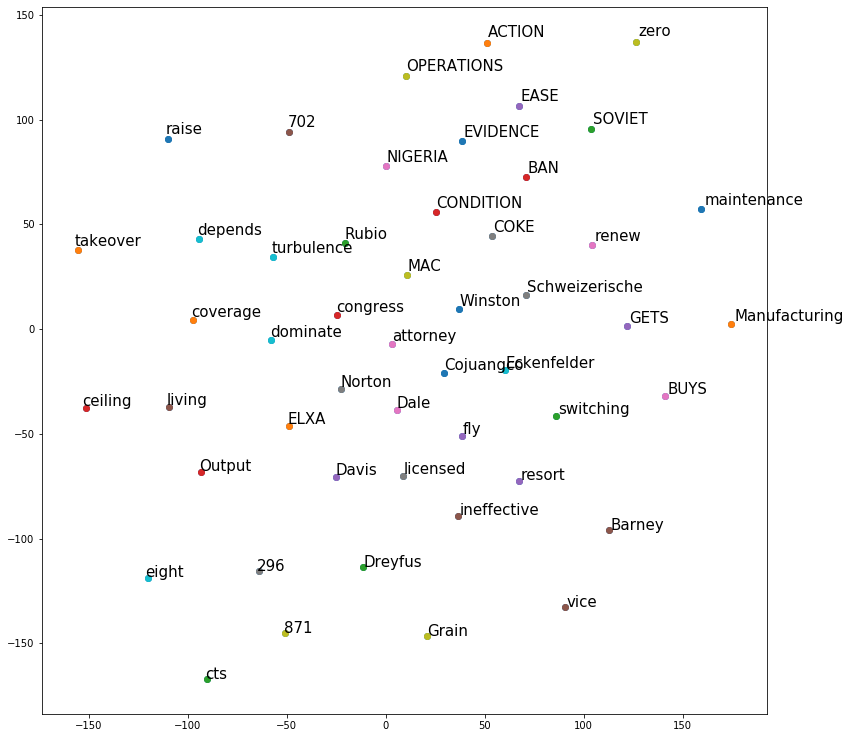

In [215]:
# we'll use TSNE to visualize w2v and fastext embeddings

random_words = np.random.choice(w2v.wv.index2word, 50, replace=False)
res = w2v[random_words]
res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

And again we don't get anything good from ploting the vectors

Let's try to query the model for similar words.

In [219]:
#there's a built in fuction for that in gensim
fast_text.wv.most_similar('bank')

[('ban', 0.9308816194534302),
 ('bankrupt', 0.9028896689414978),
 ('rank', 0.9004161357879639),
 ('banker', 0.8959032297134399),
 ('Citibank', 0.8958672881126404),
 ('sank', 0.8924193382263184),
 ('tank', 0.8733210563659668),
 ('Rank', 0.8614694476127625),
 ('banks', 0.8576824069023132),
 ('bans', 0.8505907654762268)]

In [220]:
w2v.wv.most_similar('bank')

[('central', 0.8494355082511902),
 ('bankers', 0.7750338912010193),
 ('banks', 0.7695252895355225),
 ('treasury', 0.746964693069458),
 ('outright', 0.7432740926742554),
 ('borrowings', 0.7421083450317383),
 ('Bundesbank', 0.7397869229316711),
 ('Bank', 0.7377081513404846),
 ('liquidity', 0.7343224883079529),
 ('governors', 0.711853563785553)]

This comparison makes the difference between Word2Vec and Fastext very clear. Fastext uses subword pieces for inferring a word vector, so in fastext model we get not only semantically similar words but also words that are similar in spelling. 

Fastext can also predict a vector for an unseen word if it consists of known (to the model) subword pieces. It can be particularly usefull when there are typos in the texts.

In [225]:
fast_text.wv.most_similar('banl')

[('ban', 0.9829722046852112),
 ('bank', 0.956213116645813),
 ('banks', 0.9399883151054382),
 ('bankrupt', 0.9339519739151001),
 ('bans', 0.9136940240859985),
 ('banker', 0.9088605642318726),
 ('bands', 0.9044435024261475),
 ('bankers', 0.8417877554893494),
 ('bankruptcy', 0.8345280289649963),
 ('band', 0.8317418694496155)]

Let's cluster these embbedings too.

In [227]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text.wv[word]

In [229]:
cluster = MiniBatchKMeans(1000, n_init=2, verbose=0, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

In [233]:
cls[3]

['1', '2', '3', '5', '4', '7', '6', '8', '0', '9']

In [234]:
cls[5]

['agencies',
 'lawmakers',
 'membership',
 'retailers',
 'auditors',
 'lawyers',
 'underwriters',
 'elevators',
 'chipmakers',
 'steelmakers',
 'senators',
 'destroyers',
 'inspectors',
 'legislators',
 'Negotiators',
 'Factors',
 'pacemakers',
 'insurers',
 'Advisers',
 'suitors',
 'investigators']

### Embeddings for classification

So far we only used intrinsic characteristic of a model to evaluate its quality. However, the right way to evaluate a word embedding model is using it in an underlying task with well-defined metric. 

Let's use Microsoft Paraphrasing dataset for that. The task is to predict whether two sentences are paraphrases.

In [277]:
train = pd.read_csv('msr_paraphrase_train.txt', sep='\t', engine='python', quoting=3)
train.dropna(inplace=True)
# test = pd.read_csv('msr_paraphrase_test.txt', sep='\t', engine='python', quoting=3)

In [252]:
train.columns

Index(['Quality', '#1 ID', '#2 ID', '#1 String', '#2 String'], dtype='object')

We have 4076 pairs in the training set and 1725 in the validation set.

In [249]:
train.shape

(4076, 5)

In [250]:
train.Quality.value_counts()

1    2753
0    1323
Name: Quality, dtype: int64

In [251]:
test.shape

(1725, 1)

Let's walk through the methods we tried and test them on that task.

Для решения задачи преобразуем каждый текст и конкатенируем их векторы.

In [254]:
tfidf = TfidfVectorizer(min_df=3, max_df=0.4, max_features=1000)
tfidf.fit(pd.concat([train['#1 String'], train['#2 String']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1000, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### SVD

In [264]:
svd = TruncatedSVD(200)


# we build two models 
# one for the first sentence and the other is for the second 
# you can use one model if you want
X_text_1 = svd.fit_transform(tfidf.transform(train['#1 String']))
X_text_2 = svd.fit_transform(tfidf.transform(train['#2 String']))

X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [265]:
X_text.shape

(4076, 400)

In [266]:
y = train['Quality'].values
print(y.shape)

(4076,)


We'll use simple train-test simple for validation

In [267]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.41      0.53      0.46       336
          1       0.73      0.63      0.67       683

avg / total       0.63      0.59      0.60      1019



In [268]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.57      0.23      0.33       336
          1       0.71      0.92      0.80       683

avg / total       0.66      0.69      0.64      1019



### NMF

Let's use one NMF model for both sentences

In [270]:
nmf = NMF(100)
nmf.fit(tfidf.transform(pd.concat([train['#1 String'], train['#2 String']])))

X_text_1_nmf = nmf.transform(tfidf.transform(train['#1 String']))
X_text_2_nmf = nmf.transform(tfidf.transform(train['#2 String']))

X_text_nmf = np.concatenate([X_text_1_nmf, X_text_2_nmf], axis=1)

In [271]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = LogisticRegression(C=10000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.41      0.53      0.47       336
          1       0.73      0.63      0.68       683

avg / total       0.63      0.60      0.61      1019



In [272]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.45      0.42      0.43       336
          1       0.72      0.75      0.73       683

avg / total       0.63      0.64      0.63      1019



### Word2Vec и Fastext

NMF and SVD in sklearn return document embeddings by default, but for word2vec and fastext building a document representation is not that easy. There are different methods to do so, the most popular one is just averaging the individual word vectors in the document.

In [280]:
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('english'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [word for word in words if word and word not in stops]

    return ' '.join(words)

def get_embedding(text, model, dim):
    text = normalize(text)
    
    # a little optimization 
    # let's only use an embedding for each unique word once
    # and multiply it with the frequency
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model.wv[word]
            vectors[i] = v*(words[word]/total)
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [288]:
dim = 50

fast_text = gensim.models.FastText([text.split() for text in news], size=dim, 
                                   min_n=4, max_n=8) 
w2v = gensim.models.Word2Vec([text.split() for text in news], size=dim, sg=1)


In [283]:

X_text_1_w2v = np.zeros((train.shape[0], dim))
X_text_2_w2v = np.zeros((train.shape[0], dim))

for i, text in enumerate(train['#1 String'].values):
    X_text_1_w2v[i] = get_embedding(text, w2v, dim)
    
for i, text in enumerate(train['#2 String'].values):
    X_text_2_w2v[i] = get_embedding(text, w2v, dim)

In [284]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [285]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.49      0.38      0.42       336
          1       0.72      0.81      0.76       683

avg / total       0.65      0.66      0.65      1019



In [287]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.63      0.13      0.22       336
          1       0.69      0.96      0.81       683

avg / total       0.67      0.69      0.61      1019



In [289]:
dim = 50

X_text_1_ft = np.zeros((train.shape[0], dim))
X_text_2_ft = np.zeros((train.shape[0], dim))

for i, text in enumerate(train['#1 String'].values):
    X_text_1_ft[i] = get_embedding(text, fast_text, dim)
    
for i, text in enumerate(train['#2 String'].values):
    X_text_2_ft[i] = get_embedding(text, fast_text, dim)

In [290]:
X_text_ft = np.concatenate([X_text_1_ft, X_text_2_ft], axis=1)

In [291]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_ft, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.53      0.38      0.44       336
          1       0.73      0.84      0.78       683

avg / total       0.66      0.68      0.67      1019



## Homework

You need to build a paraphraser classifier using all of the mentioned embeddings methods (NMF, SVD, W2V, Fastext) together in one model.

Instead of raw embeddings use cosine similarities between sentences as features.

In [303]:
# you need to fill this matrix with cosine distances 
# and use it to train a classifier
X = np.zeros((train.shape[0], 4))  #4 is for 4 methods 
y = train['Quality'].values

In [304]:
# here's how you compute cosine distance between a pair of sentences 
# embedded with NMF
nmf = NMF(100)
nmf.fit(tfidf.transform(pd.concat([train['#1 String'], train['#2 String']])))

X_text_1_nmf = nmf.transform(tfidf.transform(train['#1 String']))
X_text_2_nmf = nmf.transform(tfidf.transform(train['#2 String']))

In [305]:
# go by row and replace the zero in the original matrix with cosine distance
for i in range(train.shape[0]):
    X[i][0] = cosine_distances(X_text_1_nmf[i].reshape(1,-1), 
                               X_text_2_nmf[i].reshape(1, -1))[0][0]

You need to add three more methods (SVD, W2V, Fastext) so all the columns are non-zeros (now only the first one is filled with values)

In [308]:
X

array([[0.33172122, 0.        , 0.        , 0.        ],
       [0.42532288, 0.        , 0.        , 0.        ],
       [0.07186025, 0.        , 0.        , 0.        ],
       ...,
       [0.18655291, 0.        , 0.        , 0.        ],
       [0.27922108, 0.        , 0.        , 0.        ],
       [0.04760544, 0.        , 0.        , 0.        ]])

After you have filled the matrix, built a classifier and evaluate

In [309]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

          0       0.55      0.11      0.18       336
          1       0.69      0.96      0.80       683

avg / total       0.64      0.68      0.59      1019



### You must use different parameters when building the embedding models

Change the number of components in NMF and SVD, vectorization parameters, dim in w2v and fastext and optionally other parameters as well